<a href="https://colab.research.google.com/github/LNshuti/saas-winners/blob/main/power_law_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Large social networks are characterized by a few well-known phenomena:

1. **Power-Law Degree Distributions**: Many real-world social networks exhibit a **heavy-tailed** degree distribution \( P(k) \sim k^{-\alpha} \). Some networks have a “two-regime” structure, with different exponents for low-degree vs. high-degree nodes (Csányi & Szendrői, 2003).
2. **Short Characteristic Path Length** and **High Clustering**: Social networks often exhibit **small-world** properties, with relatively **short average path lengths** between nodes and **high clustering coefficients** (Corten, 2012).
3. **Distinct Components**: In online social networks, three main regions often emerge (Kumar et al., 2006):
   - Singletons (isolated nodes)
   - Isolated communities (often star-like structures)
   - A giant component, containing a well-connected core
4. **Mixed Node Types**: The composition of a social network might be modeled as a mix of:
   - **Passive members** (rarely invite or respond)
   - **Inviters** (who frequently send invitations)
   - **Active participants** (who both invite and respond)
5. **Random Graphs and Epidemic Modeling**: Some large-scale social networks resemble random graphs with power-law distributions (Eubank et al., 2004). This similarity has implications for studying epidemic spread, viral marketing, and other phenomena.

---

In this **tutorial**, we :
- Generate **synthetic social network data** in Python using **NetworkX**.
- Demonstrate how to **fit** and **visualize** power-law degree distributions.
- **Compute** short path lengths, clustering coefficients, and examine other metrics.
- Identify distinct components and subgraphs.
- Illustrate how random graphs compare to social networks from a structural perspective.

---
We will need the following libraries:

- **NetworkX** for graph construction and analysis
- **NumPy** and **pandas** for data manipulation
- **matplotlib** (and possibly **seaborn**) for visualizations
- **scipy** for statistical fitting and analysis


In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random

%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## **Generating Synthetic Network Data (Overview)**

We generate a **synthetic social network** that exhibits a power-law–like degree distribution with two scaling regimes. One typical approach is to use:
1. A **Barabási–Albert** (BA) model to generate a scale-free network with one regime.
2. Then, artificially **“merge”** it with a second smaller scale-free or star-like cluster that has its own degree behavior.

Additionally, we will add:
- **Singletons**: some fraction of nodes that are completely isolated.
- **Small star communities**: to mimic isolated groups, each with a small highly connected “hub.”
- A **giant component**: that emerges from a larger BA network.

### **Step-by-Step Reasoning**  
1. **Decide on the size of the network**: We’ll aim for ~5,000 nodes total.  
2. **Create a giant component** using a BA model with ~4,000 nodes.  
3. **Sprinkle** ~500 singleton nodes.  
4. **Add** ~10 small star subgraphs each of size ~ 30–40.  
5. **Combine** all these subgraphs into one composite “synthetic social network.”


In [3]:
# Parameters
N = 5000              # total number of nodes desired
N_giant = 4000        # nodes in the giant component
N_singletons = 500    # number of isolated nodes (singletons)
num_stars = 10        # number of small star communities
star_size = 30        # size of each star community

# 1. Create a giant component with Barabási-Albert model
m = 2  # number of edges to attach from a new node to existing nodes
G_giant = nx.barabasi_albert_graph(n=N_giant, m=m, seed=42)

# 2. Create singletons
singleton_nodes = range(N_giant, N_giant + N_singletons)
G_singletons = nx.Graph()
G_singletons.add_nodes_from(singleton_nodes)

# 3. Create star communities
# We'll create multiple star subgraphs and then merge them
G_stars = nx.Graph()
current_node_label = N_giant + N_singletons
for i in range(num_stars):
    center_node = current_node_label
    G_stars.add_node(center_node)
    # Add star_size - 1 leaf nodes
    for j in range(star_size - 1):
        leaf_node = current_node_label + j + 1
        G_stars.add_node(leaf_node)
        G_stars.add_edge(center_node, leaf_node)
    # Advance the current_node_label
    current_node_label += star_size

# 4. Combine all into a single graph
G = nx.disjoint_union_all([G_giant, G_singletons, G_stars])

print("Number of components:", nx.number_connected_components(G))
print("Total nodes:", G.number_of_nodes())
print("Total edges:", G.number_of_edges())

Number of components: 511
Total nodes: 4800
Total edges: 8286


Max degree: 172
Average degree: 3.4525


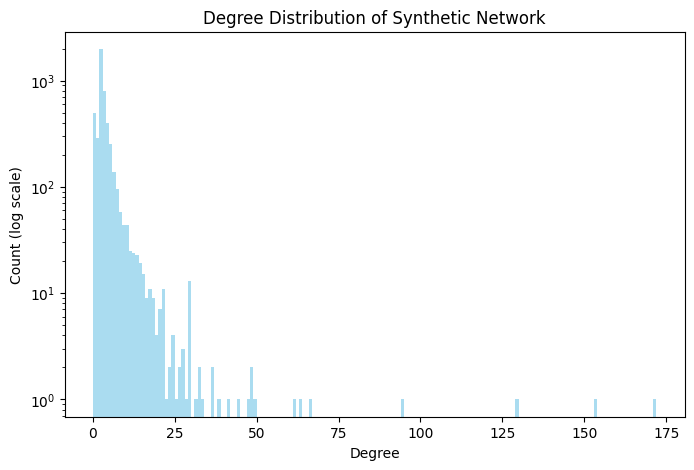

In [4]:
degrees = [deg for _, deg in G.degree()]
max_degree = max(degrees)

print("Max degree:", max_degree)
print("Average degree:", np.mean(degrees))

# Plot histogram of degrees
plt.figure(figsize=(8,5))
plt.hist(degrees, bins=range(0, max_degree+1), color='skyblue', alpha=0.7)
plt.yscale('log')
plt.xlabel("Degree")
plt.ylabel("Count (log scale)")
plt.title("Degree Distribution of Synthetic Network")
plt.show()

## **Generating Synthetic Data (Implementation)**

- We used **`nx.barabasi_albert_graph(...)`** to create a scale-free subgraph as the “giant component.”
- **Singletons** are just nodes with no edges.
- **Star communities** each have one central hub and several leaves attached to it.
- We use **`nx.disjoint_union_all([...])`** to combine these into a single “synthetic social network.”

We should have ~5000 nodes, partitioned into the giant component, singletons, and multiple star communities.

---

## **Basic Analysis (Degree Distribution & Visualization)**

Next, let’s look at some basic statistics:

- Degree distribution
- Simple visualization (although with 5,000 nodes, a direct plot may be messy)


- We **log-scale** the y-axis to highlight the heavy-tail nature.
- Notice that you’ll see a significant chunk at **degree=0** (the singletons) and possibly a second bump from the star clusters.
- The giant component’s BA-like structure should lead to a heavy tail on higher degrees.

---

## **Checking for Power-Law Fit**

To see if we have a power-law tail, we can:
1. Ignore the zero-degree nodes.
2. Ignore the extremely high-degree outliers (if desired).
3. Attempt to fit a power law to the remaining degrees.

We’ll do a simple approach using **numpy**. (For more advanced fits, consider the `powerlaw` package.)

- The slope on the **log-log** plot is related to the power-law exponent \( \alpha \) by \(\text{slope} \approx -\alpha\).
- We expect an exponent typically in the range \([2, 3]\) for social networks, but our two-regime approach might complicate a single power-law fit.

---

## **Small-World Properties (Path Length, Clustering)**

Large social networks often exhibit **short characteristic path lengths** and **high clustering coefficients**. Let’s measure:

- **Average shortest path length** (on the giant component only, because singletons are disconnected).
- **Average clustering coefficient** (again focusing on the giant component).


- The **`max(nx.connected_components(G), key=len)`** approach picks the largest connected set of nodes.
- We can only compute shortest path length on a connected subgraph.
- Typical “small-world” networks might have an average path length on the order of \(\log(N)\) or smaller.
- Social networks often also have an above-random clustering coefficient.

---

## **Identifying Key Regions in the Network**

Based on **Kumar et al. (2006)**, online social networks may have:
1. **Singletons**
2. **Isolated star-like communities**
3. **Giant component** with a core

Let’s see how many components we have and identify them by size. We already see singletons are in their own component. We can also see the star subgraphs. We’ll label components by size:


- The largest component should correspond to our BA-based “giant” subgraph of size \(\sim 4000\).
- There should be **500** singleton components total (if none were accidentally merged).
- The next largest components (size = 30) should correspond to our star communities.


Estimated power-law exponent (approx): 2.140395457683688


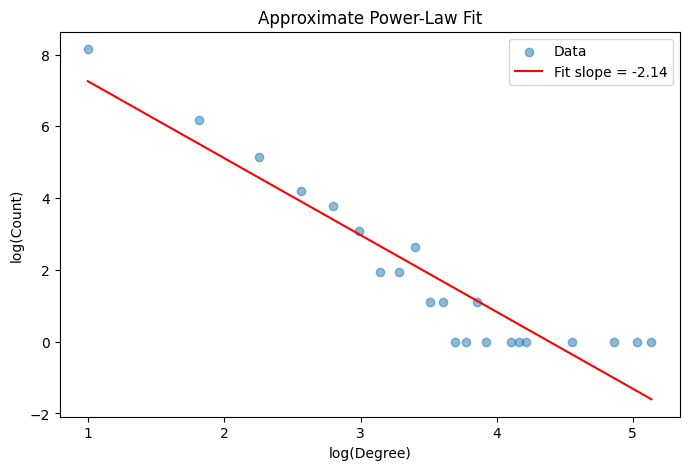

In [5]:
# Filter out degree=0 nodes
nonzero_degrees = [d for d in degrees if d > 0]

# Simple log-log approach
counts, bin_edges = np.histogram(nonzero_degrees, bins=50)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

nonzero_mask = (counts > 0)
bin_centers = bin_centers[nonzero_mask]
counts = counts[nonzero_mask]

log_bin_centers = np.log(bin_centers)
log_counts = np.log(counts)

# Linear fit on log-log scale
slope, intercept = np.polyfit(log_bin_centers, log_counts, 1)

print("Estimated power-law exponent (approx):", -slope)

plt.figure(figsize=(8,5))
plt.scatter(log_bin_centers, log_counts, label='Data', alpha=0.5)
plt.plot(log_bin_centers, intercept + slope*log_bin_centers, color='red',
         label=f'Fit slope = {slope:.2f}')
plt.xlabel("log(Degree)")
plt.ylabel("log(Count)")
plt.title("Approximate Power-Law Fit")
plt.legend()
plt.show()


## **Modeling Node Types (Passive, Inviters, Active Participants)**

To **model different node types** (Kumar et al., 2006) in a synthetic sense, we can:
1. **Assign** each node a role: “Passive,” “Inviter,” or “Active,” based on degree or random sampling.
2. For instance, we can say:
   - “Passive” nodes have degree \( < 2\).
   - “Inviters” have a moderate degree (2 to 10).
   - “Active participants” have degree \( > 10\).
3. Alternatively, random assignment with different proportions could be used.

Let’s do the degree-based approach for demonstration:

- This is a simplistic model, but it illustrates how we can **tag** each node with a certain “behavioral” label.
- In a real system, these labels might come from user logs or other dynamic behaviors.

In [6]:
# Extract the giant component subgraph
giant_components = list(nx.connected_components(G))
giant_component_nodes = max(giant_components, key=len)
G_giant_sub = G.subgraph(giant_component_nodes).copy()

# Average shortest path length
avg_path_length = nx.average_shortest_path_length(G_giant_sub)
# Average clustering
avg_clustering = nx.average_clustering(G_giant_sub)

print("Number of nodes in giant component:", len(G_giant_sub))
print("Average shortest path length (giant component):", avg_path_length)
print("Average clustering coefficient (giant component):", avg_clustering)


Number of nodes in giant component: 4000
Average shortest path length (giant component): 4.674114153538385
Average clustering coefficient (giant component): 0.008708675530481685


In [7]:
components = list(nx.connected_components(G))
component_sizes = [len(c) for c in components]
sorted_sizes = sorted(component_sizes, reverse=True)

print("Number of components:", len(components))
print("Largest 10 component sizes:", sorted_sizes[:10])

# Identify singleton count
singleton_count = sum([1 for size in component_sizes if size == 1])
print("Number of singleton components:", singleton_count)

Number of components: 511
Largest 10 component sizes: [4000, 30, 30, 30, 30, 30, 30, 30, 30, 30]
Number of singleton components: 500



---

## **Comparison with Random Graphs & Conclusion**

Finally, let’s **compare** our synthetic social network to a **classical random graph** \(G_{n,p}\) with the same number of nodes and approximately the same average degree. Then we’ll **briefly summarize** what we learned.


In [8]:
node_types = {}
for node in G.nodes():
    deg = G.degree(node)
    if deg < 2:
        node_types[node] = "Passive"
    elif deg <= 10:
        node_types[node] = "Inviter"
    else:
        node_types[node] = "Active"

# Quick count
from collections import Counter
type_counts = Counter(node_types.values())
print("Type counts:", type_counts)

Type counts: Counter({'Inviter': 3806, 'Passive': 790, 'Active': 204})


In [9]:
# We know total edges in G:
E = G.number_of_edges()
avg_degree_est = 2.0 * E / G.number_of_nodes()
p = avg_degree_est / (G.number_of_nodes() - 1)

# Construct a random graph with same N and similar p
N_total = G.number_of_nodes()
G_erdos_renyi = nx.erdos_renyi_graph(N_total, p, seed=42)

# Compare average shortest path lengths on their giant components
def get_giant_subgraph(graph):
    components = list(nx.connected_components(graph))
    giant_nodes = max(components, key=len)
    return graph.subgraph(giant_nodes).copy()

G_giant_sub_rand = get_giant_subgraph(G_erdos_renyi)

print("Erdős–Rényi graph giant component size:",
      len(G_giant_sub_rand))

print("Erdős–Rényi average path length:",
      nx.average_shortest_path_length(G_giant_sub_rand))
print("Erdős–Rényi average clustering:",
      nx.average_clustering(G_giant_sub_rand))

Erdős–Rényi graph giant component size: 4636
Erdős–Rényi average path length: 7.088277194657821
Erdős–Rényi average clustering: 0.0006138981333114206




1. **Power-Law Distributions**: Our synthetic network shows a heavy-tailed degree distribution, with clear substructures for singletons and star communities, partially mimicking the **two-regime** phenomenon.
2. **Short Paths & High Clustering**: The giant component exhibits features reminiscent of a small-world network.
3. **Distinct Regions**: We can see the singletons, small star subgraphs, and a giant component, consistent with what Kumar et al. (2006) describes.
4. **Passive / Inviter / Active**: A naive classification shows how we can label nodes by degree.
5. **Random Graph Comparison**: The Erdős–Rényi network might have a different degree distribution (Poisson-like) and different clustering behavior. By comparing average path lengths and clustering, we see how real social networks deviate from purely random graphs.

These steps provide a foundation for **analyzing large-scale social networks**. In a production system, you would:
- Pull actual data from a data warehouse,
- Apply distributed graph algorithms (e.g., GraphFrames or PySpark GraphX),
- Conduct advanced power-law fits,
- Use specialized clustering algorithms for community detection,
- And carefully interpret the results for business applications (e.g., user engagement, churn prediction, recommendation systems).

**Next Steps** :
- Incorporating “temporal edges” or “temporal features” for dynamic analyses (e.g., how the network evolves over time).
- Refining node-type modeling with more realistic assumptions.
- Running **epidemic simulations** or **influence spread** experiments on the network.